In [5]:
import sys
sys.path.append("../src")

import mechanism_with_policy_graph
import map_processor
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
def make_set_of_connected_states(states, graph_mat):
    n_states = len(states)

    G = nx.Graph()
    G.add_nodes_from(states)

    for i, state in enumerate(states):
        for state_ in states[i+1:]:
            if graph_mat[state, state_] == 1:
                G.add_edge(state, state_)

    set_of_connected_states = [list(nodes) for nodes in nx.connected_components(G) if len(nodes) != 1]

    return set_of_connected_states

def connected_states(state, set_of_states):
    for states in set_of_states:
        if state in states:
            return states

n_x_lattice = 50
r = 500

placeID = 3
min_lon, max_lon, min_lat, max_lat = 139.6, 139.75, 35.68, 35.8

epsilons = [0.1, 0.3, 0.5, 0.8, 1, 2, 5]

data_dir = os.path.join("/", "data", "takagi", "globefish")

In [6]:
def perturb_distance(mec, mp, true_states, sample_states, epsilon=1, sample_num=10000):
    
    states = mp.possible_states
    set_of_connected_states = make_set_of_connected_states(states, mp.graph_mat)

    true_coords = np.zeros((sample_num, 2))
    perturbed_coords = np.zeros((sample_num, 2))
    
    is_sames = []
    
    for i in range(sample_num):

        true_state = np.random.choice(sample_states)
        true_coord = mp.state_to_coord(true_state)

        connected_states_of_true_state = connected_states(true_state, set_of_connected_states)
        connected_coords_of_true_state = mp.states_to_coords(connected_states_of_true_state)

        mec.load(connected_coords_of_true_state, connected_states_of_true_state, mp.graph_mat)
        mec.build_distribution(epsilon)
        perturbed_coord, perturbed_state = mec.perturb(true_coord)

        true_coords[i,:] = true_coord
        perturbed_coords[i, :] = perturbed_coord
        
        is_sames.append(perturbed_state in true_states)
        
    ave_sames = np.sum(is_sames) / len(is_sames)
        
    return np.average(np.linalg.norm(true_coords - perturbed_coords, axis=1)) * mp.lattice_length, ave_sames

def result(mec, mp, true_states, sample_states, epsilons, sample_num=200):
    distances = []
    sames = []
    for epsilon in epsilons:
        distance, same = perturb_distance(mec, mp, true_states, sample_states, epsilon, sample_num)
        distances.append(distance)
        sames.append(same)
    return distances, sames

def plot(epsilons, pim_distances, lm_distances):
    plt.plot(epsilons, pim_distances, label="PIM")
    plt.plot(epsilons, lm_distances, label="LM")
    plt.legend()
    plt.xlabel("$\epsilon$")
    plt.ylabel("Euclidean distance")
    plt.show()
    
def plot_same(epsilons, pim_sames, lm_sames):
    plt.plot(epsilons, pim_sames, label="PIM")
    plt.plot(epsilons, lm_sames, label="LM")
    plt.legend()
    plt.xlabel("$\epsilon$")
    plt.ylabel("same probability")
    plt.show()

# True State => $G_{k9}$

In [7]:
n_split = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_area_n_split{n_split}_r{r}_n_x{n_x_lattice}.jbl"))
true_states = mp.areas[0]

placeID = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_placeID{placeID}_r{r}_n_x{n_x_lattice}.jbl"))
true_states_ = mp.possible_states 

sample_states = list(set(true_states) & set(true_states_))

### $G_{k9}$

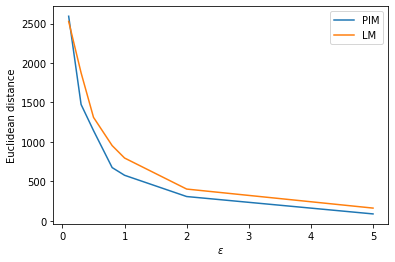

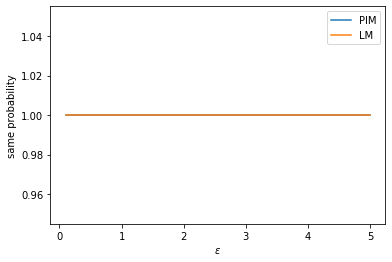

In [8]:
n_split = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_area_n_split{n_split}_r{r}_n_x{n_x_lattice}.jbl"))

np.random.seed(0)
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
pim_distances, pim_sames = result(pim_with_pg, mp, true_states, sample_states, epsilons)

np.random.seed(0)
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()
lm_distances, lm_sames = result(lm_with_pg, mp, true_states, sample_states, epsilons)

plot(epsilons, pim_distances, lm_distances)
plot_same(epsilons, pim_sames, lm_sames)

### $G_{k16}$

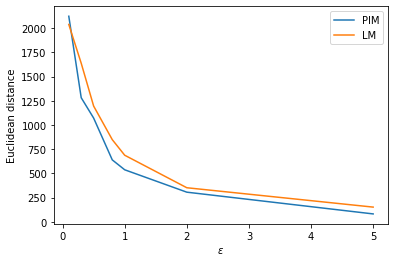

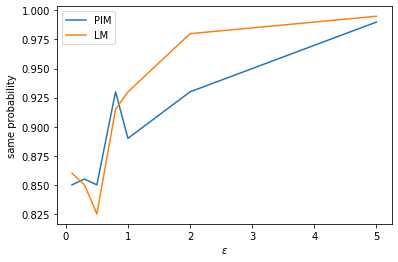

In [9]:
n_split = 4
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_area_n_split{n_split}_r{r}_n_x{n_x_lattice}.jbl"))

np.random.seed(0)
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
pim_distances, pim_sames = result(pim_with_pg, mp, true_states, sample_states, epsilons)

np.random.seed(0)
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()
lm_distances, lm_sames = result(lm_with_pg, mp, true_states, sample_states, epsilons)

plot(epsilons, pim_distances, lm_distances)
plot_same(epsilons, pim_sames, lm_sames)

### $G_{POI}$

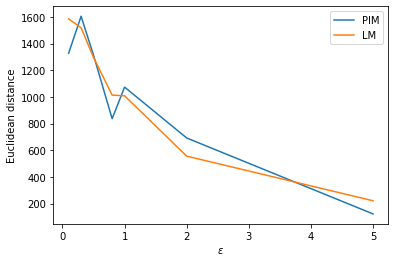

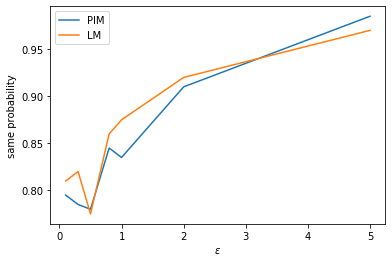

In [10]:
placeID = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_placeID{placeID}_r{r}_n_x{n_x_lattice}.jbl"))

np.random.seed(0)
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
pim_distances, pim_sames = result(pim_with_pg, mp, true_states, sample_states, epsilons)

np.random.seed(0)
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()
lm_distances, lm_sames = result(lm_with_pg, mp, true_states, sample_states, epsilons)

plot(epsilons, pim_distances, lm_distances)
plot_same(epsilons, pim_sames, lm_sames)

# True State => $G_{POI}$

In [11]:
n_split = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_area_n_split{n_split}_r{r}_n_x{n_x_lattice}.jbl"))
true_states_ = mp.areas[0]

placeID = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_placeID{placeID}_r{r}_n_x{n_x_lattice}.jbl"))
true_states = mp.possible_states 

sample_states = list(set(true_states) & set(true_states_))

### $G_{k9}$

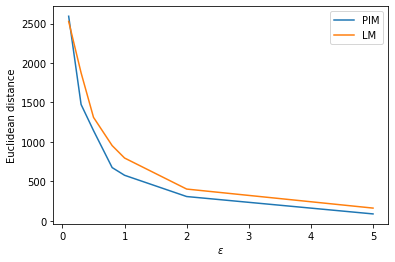

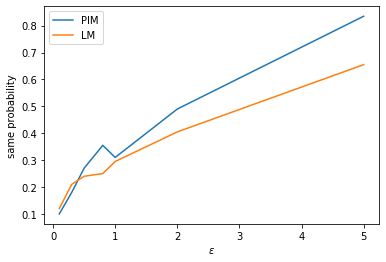

In [12]:
n_split = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_area_n_split{n_split}_r{r}_n_x{n_x_lattice}.jbl"))

np.random.seed(0)
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
pim_distances, pim_sames = result(pim_with_pg, mp, true_states, sample_states, epsilons)

np.random.seed(0)
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()
lm_distances, lm_sames = result(lm_with_pg, mp, true_states, sample_states, epsilons)

plot(epsilons, pim_distances, lm_distances)
plot_same(epsilons, pim_sames, lm_sames)

### $G_{k16}$

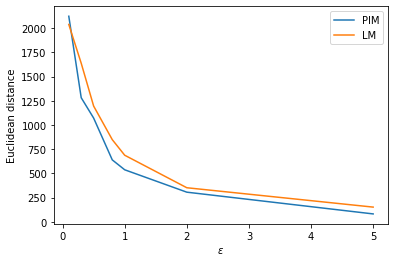

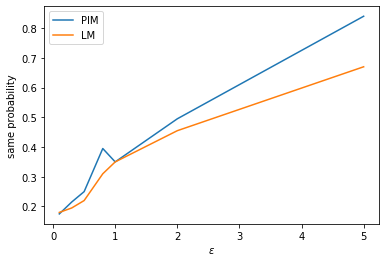

In [13]:
n_split = 4
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_area_n_split{n_split}_r{r}_n_x{n_x_lattice}.jbl"))

np.random.seed(0)
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
pim_distances, pim_sames = result(pim_with_pg, mp, true_states, sample_states, epsilons)

np.random.seed(0)
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()
lm_distances, lm_sames = result(lm_with_pg, mp, true_states, sample_states, epsilons)

plot(epsilons, pim_distances, lm_distances)
plot_same(epsilons, pim_sames, lm_sames)

### $G_{POI}$

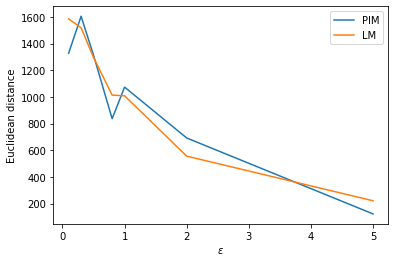

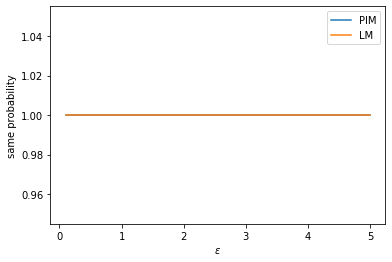

In [15]:
placeID = 3
mp = joblib.load(filename=os.path.join(data_dir, f"{min_lon}_{max_lon}_{min_lat}_{max_lat}_placeID{placeID}_r{r}_n_x{n_x_lattice}.jbl"))

np.random.seed(0)
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
pim_distances, pim_sames = result(pim_with_pg, mp, true_states, sample_states, epsilons)

np.random.seed(0)
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()
lm_distances, lm_sames = result(lm_with_pg, mp, true_states, sample_states, epsilons)

plot(epsilons, pim_distances, lm_distances)
plot_same(epsilons, pim_sames, lm_sames)